In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
import seaborn as sns
from model import loss
from model import reverse_se3_diffusion
import tree
import pandas as pd
import mdtraj as md
import plotnine as gg
from openfold.np.relax import amber_minimize
from data import rosetta_data_loader
from data import digs_data_loader
from data import all_atom
from experiments import train_se3_diffusion
from experiments import inference_se3_diffusion
from openfold.utils import rigid_utils as ru
from openfold.np import residue_constants
from scipy.spatial.transform import Rotation

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
INFO: Using numpy backend


In [2]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(au)
importlib.reload(all_atom)
importlib.reload(plotting)
importlib.reload(loss)
importlib.reload(reverse_se3_diffusion)
importlib.reload(inference_se3_diffusion)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [3]:
processed_pdb_dir = '/data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff'
processed_pdb_csv_path = os.path.join(processed_pdb_dir, 'metadata.csv')
csv_df = pd.read_csv(processed_pdb_csv_path)

In [4]:
csv_df.radius_gyration = csv_df.radius_gyration.map(lambda x: float(x.replace('[', '').replace(']', '').split(' ')[0]))

In [95]:
filtered_df = csv_df[csv_df.oligomeric_detail.isin(
    ['monomeric', 'dimeric', 'trimeric', 'tetrameric']
)]
monomer_df = csv_df[csv_df.oligomeric_detail.isin(
    ['monomeric']
)]
monomer_df = monomer_df[monomer_df.coil_percent < 1.0]
monomer_df = monomer_df[monomer_df.helix_percent < 1.0]
monomer_df = monomer_df[monomer_df.strand_percent < 1.0]

## RoG correlation analysis

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 155 rows containing non-finite values.


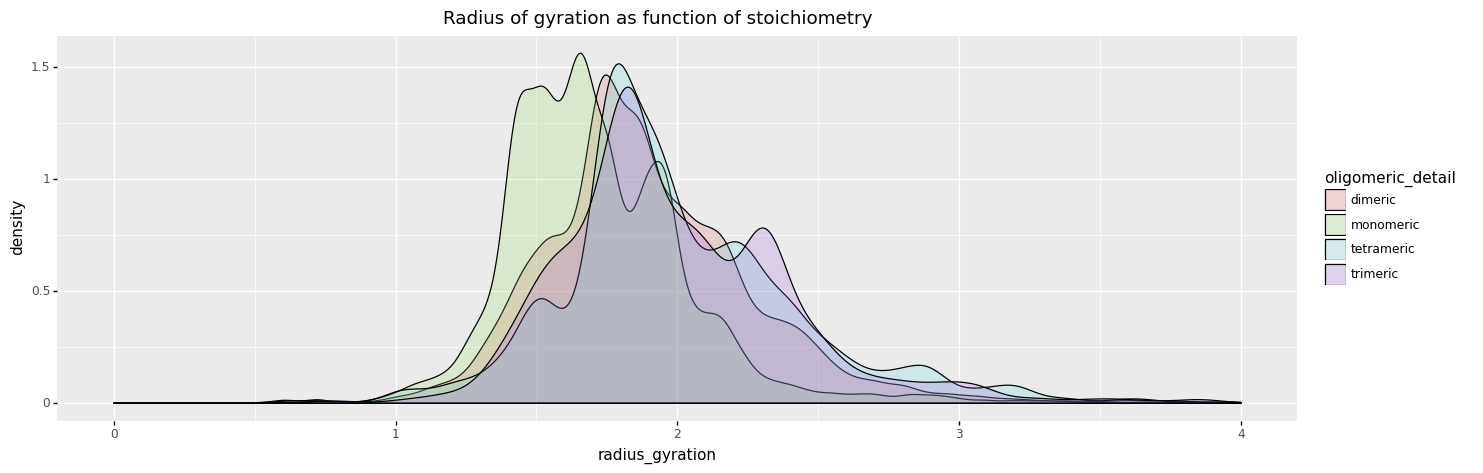

<ggplot: (8731406714200)>

In [89]:
(
    gg.ggplot(filtered_df, gg.aes(x='radius_gyration', fill='oligomeric_detail'))
    + gg.geom_density(alpha=0.2)
    + gg.scales.xlim(0, 4)
    + gg.theme(
        figure_size=(16, 5),
    )
    + gg.labs(title='Radius of gyration as function of stoichiometry')
)

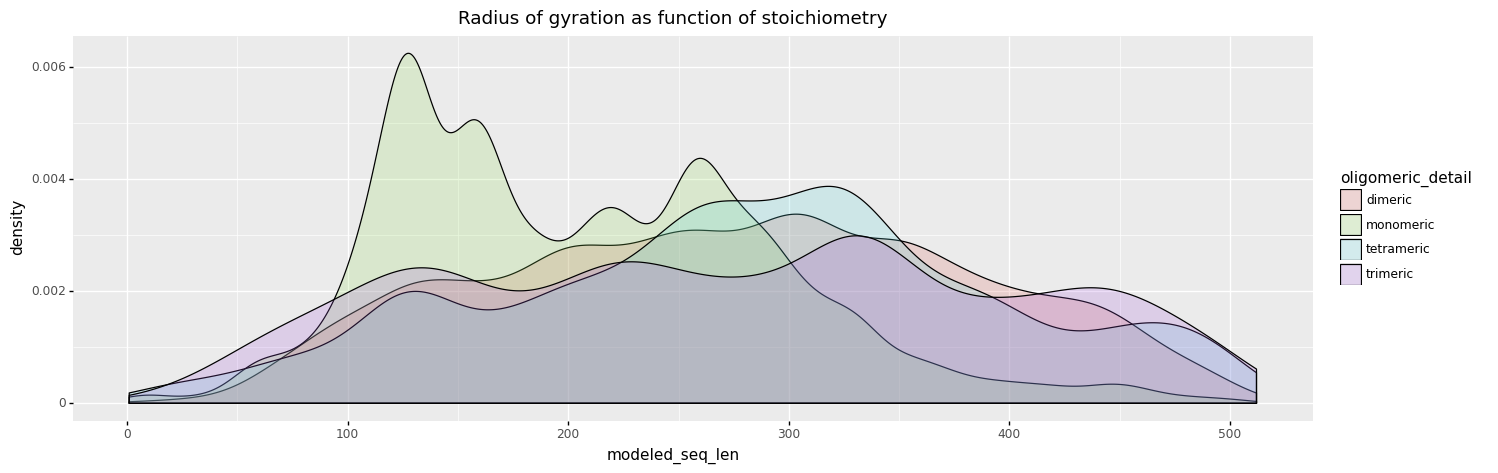

<ggplot: (8731406264296)>

In [91]:
(
    gg.ggplot(filtered_df, gg.aes(x='modeled_seq_len', fill='oligomeric_detail'))
    + gg.geom_density(alpha=0.2)
    # + gg.scales.xlim(0, 4)
    + gg.theme(
        figure_size=(16, 5),
    )
    + gg.labs(title='Radius of gyration as function of stoichiometry')
)

In [32]:
filtered_df.head()

,pdb_name,processed_path,raw_path,oligomeric_count,oligomeric_detail,resolution,structure_method,num_chains,quaternary_category,seq_len,modeled_seq_len,coil_percent,helix_percent,strand_percent,radius_gyration
0,3tvq,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.670,x-ray diffraction,1,homomer,307,152,0.243421,0.315789,0.440789,1.544820
1,3tvc,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,2.430,x-ray diffraction,1,homomer,283,169,0.579882,0.248521,0.171598,1.532785
2,4tvh,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,2,dimeric,2.195,x-ray diffraction,2,heteromer,260,232,0.340517,0.047414,0.465517,1.728409
4,6tv4,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.530,x-ray diffraction,1,homomer,488,353,0.481586,0.345609,0.172805,1.989961
5,1tvx,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,4,tetrameric,1.720,x-ray diffraction,4,heteromer,417,372,0.338710,0.161290,0.225806,1.791307


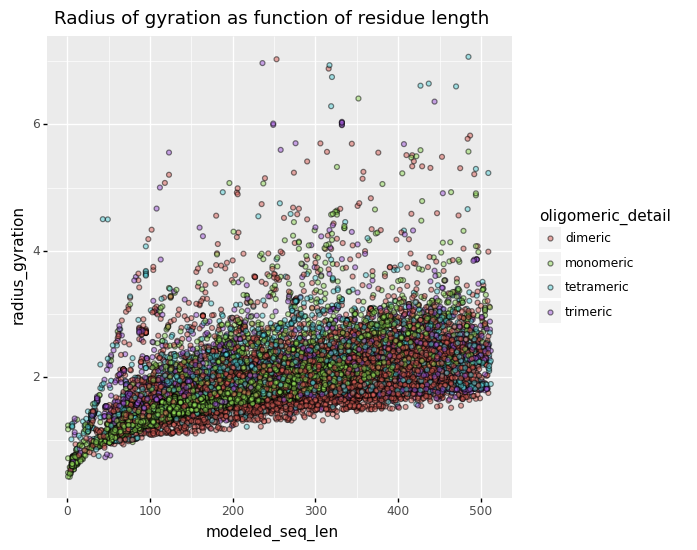

<ggplot: (8731434962622)>

In [94]:
(
    gg.ggplot(filtered_df, gg.aes(x='modeled_seq_len', y='radius_gyration', fill='oligomeric_detail'))
    + gg.geom_point(alpha=0.5)
    # + gg.geom_smooth(method='loess', se=True, span=0.9)
    + gg.theme(
        figure_size=(6, 6),
    )
    + gg.labs(title='Radius of gyration as function of residue length')
)

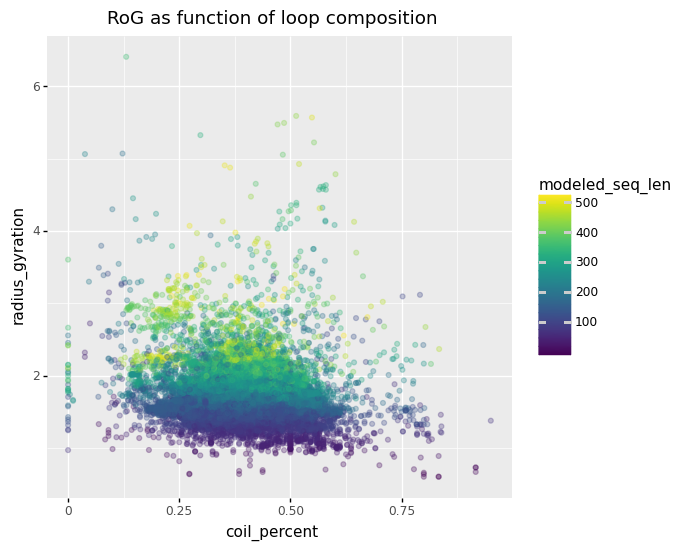

<ggplot: (8731438174922)>

In [80]:
(
    gg.ggplot(monomer_df, gg.aes(x='coil_percent', y='radius_gyration', color='modeled_seq_len'))
    + gg.geom_point(alpha=0.3)
    + gg.theme(
        figure_size=(6, 6),
    )
    + gg.labs(title='RoG as function of loop composition')
)

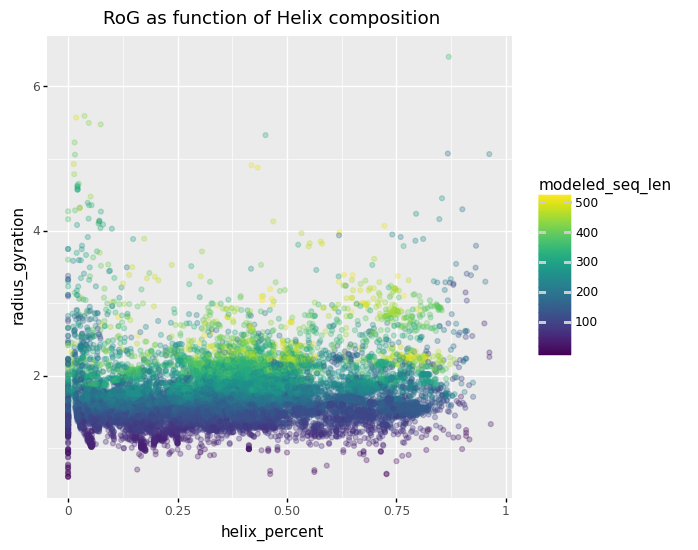

<ggplot: (8731438169736)>

In [83]:

(
    gg.ggplot(monomer_df, gg.aes(x='helix_percent', y='radius_gyration', color='modeled_seq_len'))
    + gg.geom_point(alpha=0.3)
    + gg.theme(
        figure_size=(6, 6),
    )
    + gg.labs(title='RoG as function of Helix composition')
)

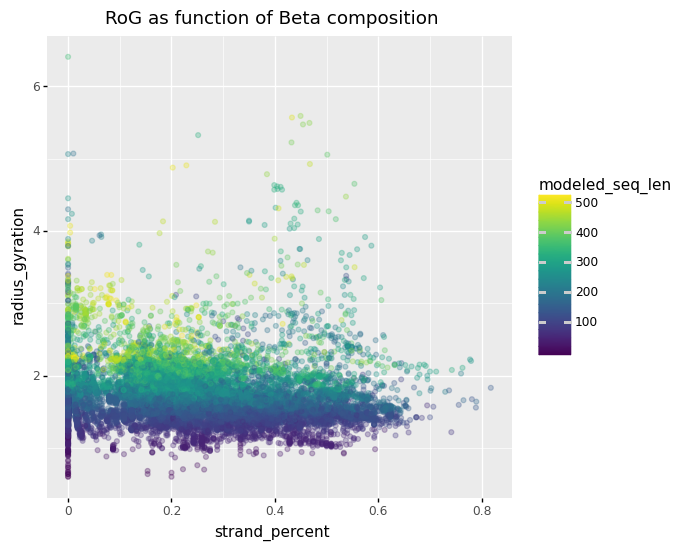

<ggplot: (8731408457213)>

In [84]:

(
    gg.ggplot(monomer_df, gg.aes(x='strand_percent', y='radius_gyration', color='modeled_seq_len'))
    + gg.geom_point(alpha=0.3)
    + gg.theme(
        figure_size=(6, 6),
    )
    + gg.labs(title='RoG as function of Beta composition')
)

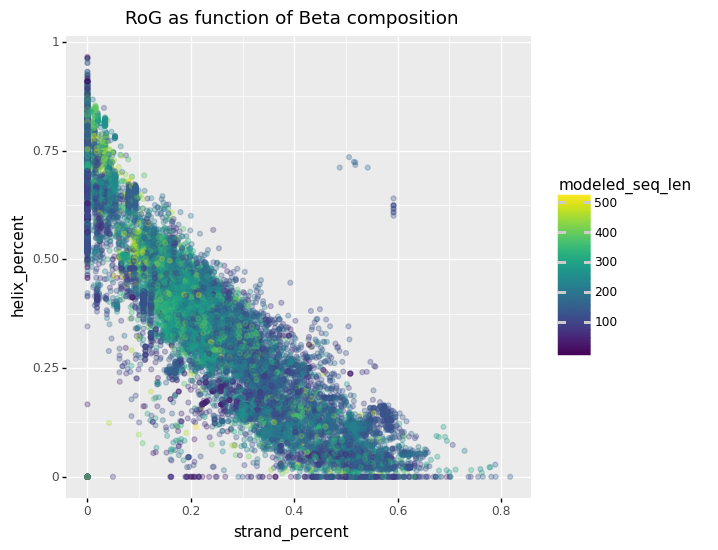

<ggplot: (8731407406035)>

In [86]:

(
    gg.ggplot(monomer_df, gg.aes(x='strand_percent', y='helix_percent', color='modeled_seq_len'))
    + gg.geom_point(alpha=0.3)
    + gg.theme(
        figure_size=(6, 6),
    )
    + gg.labs(title='RoG as function of Beta composition')
)

## RoG Filtering

In [323]:
ss_filtered_monomer_df = monomer_df[
    (monomer_df.helix_percent < 0.7)
    & (monomer_df.coil_percent < 0.5)
    & (monomer_df.strand_percent > 0.1)
]

print(monomer_df.shape)
print(ss_filtered_monomer_df.shape)
ss_filtered_monomer_df[
    (60 < ss_filtered_monomer_df.modeled_seq_len)
    & (ss_filtered_monomer_df.modeled_seq_len < 260)].shape

(24022, 16)
(15793, 16)


(10322, 16)

In [319]:
ss_filtered_monomer_df[
    (60 < ss_filtered_monomer_df.modeled_seq_len)
    & (ss_filtered_monomer_df.modeled_seq_len < 260)].shape

(10322, 16)

In [137]:
ss_filtered_df = filtered_df[
    (filtered_df.helix_percent < 0.7)
    & (filtered_df.coil_percent < 0.5)
    & (filtered_df.strand_percent > 0.1)
]

print(filtered_df.shape)
print(ss_filtered_df.shape)

(44118, 16)
(29631, 16)


In [ ]:
ss_filtered_df['SS filtered'] = True
filtered_df['SS filtered'] = False
all_df = pd.concat([ss_filtered_df, filtered_df])

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 191 rows containing non-finite values.


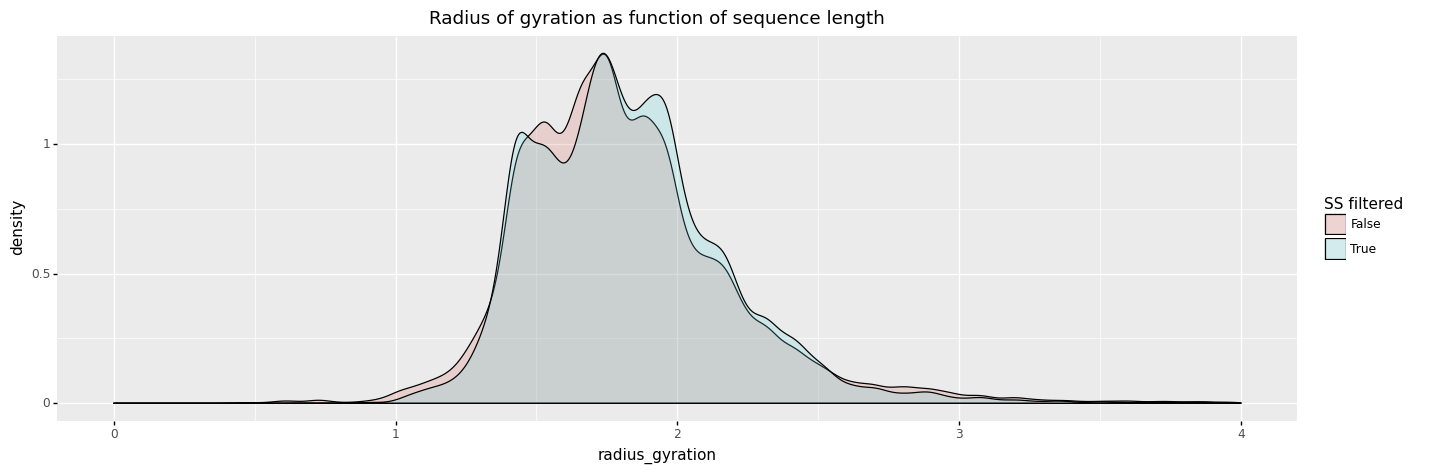

<ggplot: (8731441415446)>

In [130]:
(
    gg.ggplot(all_df, gg.aes(x='radius_gyration', fill='SS filtered'))
    + gg.geom_density(alpha=0.2)
    + gg.scales.xlim(0, 4)
    + gg.theme(
        figure_size=(16, 5),
    )
    + gg.labs(title='Radius of gyration as function of sequence length')
)

In [131]:
ss_filtered_monomer_df['SS filtered'] = True
monomer_df['SS filtered'] = False
all_monomer_df = pd.concat([ss_filtered_monomer_df, monomer_df])

/tmp/ipykernel_81265/3782890348.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 61 rows containing non-finite values.


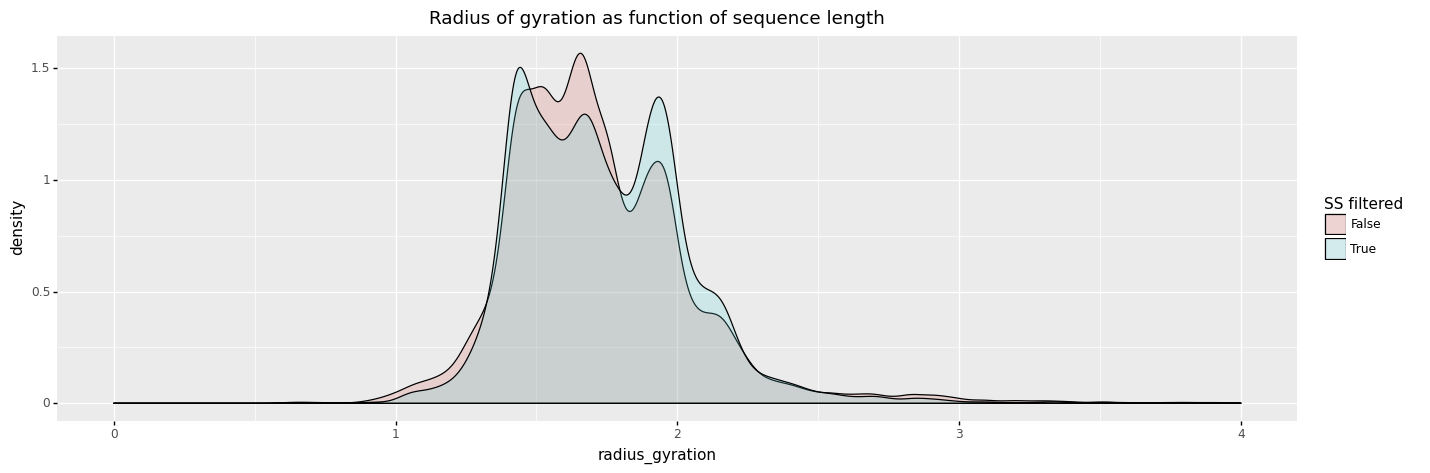

<ggplot: (8731416368336)>

In [132]:
(
    gg.ggplot(all_monomer_df, gg.aes(x='radius_gyration', fill='SS filtered'))
    + gg.geom_density(alpha=0.2)
    + gg.scales.xlim(0, 4)
    + gg.theme(
        figure_size=(16, 5),
    )
    + gg.labs(title='Radius of gyration as function of sequence length')
)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [324]:
df = filtered_df
df = monomer_df
df = ss_filtered_monomer_df

x = df.modeled_seq_len.to_numpy()
y = df.radius_gyration.to_numpy()

In [329]:
quantile = 0.96
y_quant = pd.pivot_table(
    df,
    values='radius_gyration', 
    index='modeled_seq_len',
    aggfunc=lambda x: np.quantile(x, quantile)
)

In [330]:
x_quant = y_quant.index.to_numpy()
y_cutoff = y_quant.radius_gyration.to_numpy()

In [336]:
# Fit polynomial regressor
poly = PolynomialFeatures(degree=4, include_bias=True)
poly_features = poly.fit_transform(x_quant[:, None])
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_cutoff)

# Calculate cutoff for all sequence lengths
pred_x = np.arange(512)
pred_poly_features = poly.fit_transform(pred_x[:, None])
# Add a little more.
pred_y = poly_reg_model.predict(pred_poly_features) + 0.1

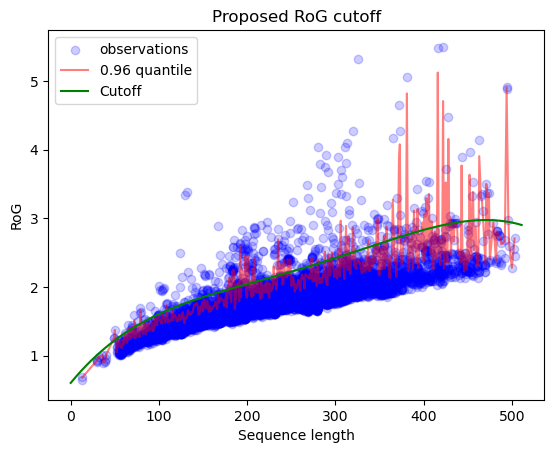

In [337]:
plt.scatter(x, y, c='blue', alpha=0.2, label='observations')
plt.plot(x_quant, y_cutoff, c='red', alpha=0.5, label=f'{quantile} quantile')
plt.plot(pred_x, pred_y, c='green', label='Cutoff')
plt.legend(loc='upper left')
plt.xlabel('Sequence length')
plt.ylabel('RoG')
plt.title('Proposed RoG cutoff')
plt.show()

In [343]:
post_rog_df = ss_filtered_monomer_df[ss_filtered_monomer_df.radius_gyration < ss_filtered_monomer_df.modeled_seq_len.map(lambda x: pred_y[x-1])]

In [344]:
post_rog_df[post_rog_df.modeled_seq_len < 260].shape

(10183, 16)

In [ ]:
pd.pivot_table(
    monomer_df
)

In [ ]:
pd.pivot_table(
    monomer_df,
    values='radius_gyration', 
    index='num_res',
    aggfunc=np.mean
)

In [313]:
quantile = 0.9
y_quant = pd.pivot_table(
    df,
    values='radius_gyration', 
    index='modeled_seq_len',
    aggfunc=lambda x: np.quantile(x, quantile)
)

In [315]:
df.head()

,pdb_name,processed_path,raw_path,oligomeric_count,oligomeric_detail,resolution,structure_method,num_chains,quaternary_category,seq_len,modeled_seq_len,coil_percent,helix_percent,strand_percent,radius_gyration,SS filtered
0,3tvq,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.670,x-ray diffraction,1,homomer,307,152,0.243421,0.315789,0.440789,1.544820,False
1,3tvc,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,2.430,x-ray diffraction,1,homomer,283,169,0.579882,0.248521,0.171598,1.532785,False
2,4tvh,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,2,dimeric,2.195,x-ray diffraction,2,heteromer,260,232,0.340517,0.047414,0.465517,1.728409,False
4,6tv4,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.530,x-ray diffraction,1,homomer,488,353,0.481586,0.345609,0.172805,1.989961,False
5,1tvx,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,4,tetrameric,1.720,x-ray diffraction,4,heteromer,417,372,0.338710,0.161290,0.225806,1.791307,False


In [316]:
df.num_chains.mean()

1.4102633845595902

In [145]:
x.shape

(24022,)

In [148]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [207]:
poly = PolynomialFeatures(degree=4, include_bias=True)
poly_features = poly.fit_transform(x[:, None])

In [208]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)

LinearRegression()

In [209]:
pred_x = np.arange(500)
pred_poly_features = poly.fit_transform(pred_x[:, None])
pred_y = poly_reg_model.predict(pred_poly_features)

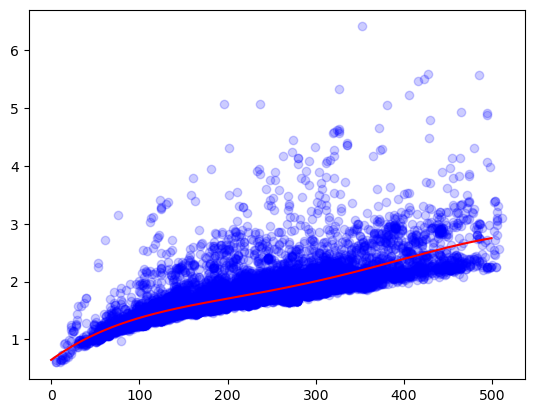

In [210]:
plt.scatter(x, y, c='blue', alpha=0.2)
plt.plot(pred_x, pred_y, c='red')
plt.show()

In [214]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel)
gaussian_process.fit(x[:, None], y)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1))

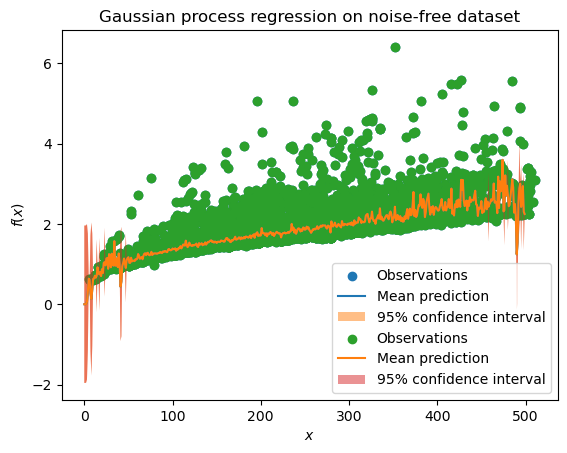

In [217]:
mean_prediction, std_prediction = gaussian_process.predict(pred_x[:, None], return_std=True)

# plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(x, y, label="Observations")
plt.plot(pred_x, mean_prediction, label="Mean prediction")
plt.fill_between(
    pred_x.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")
plt.show()